코드 생성

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate
from mpl_toolkits.mplot3d import Axes3D
from collections import deque  
import random as rand

sats = [(1, 5), (2, 6), (3, 7), (4, 8), (0, 8), (1, 9), (0, 7), (1, 8), (2, 9), (1, 2),
            (2, 3), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (0, 3), (1, 4), (2, 5), (3, 6),
            (4, 7), (5, 8), (0, 2), (3, 5), (4, 6), (5, 7), (6, 8), (7, 9), (0, 5), (1, 6),
            (2, 7), (3, 8), (4, 9), (3, 9), (0, 6), (1, 7), (3, 9)]
g1tap = [2,9]
g2tap = [1,2,5,7,8,9]
# -5000, -4500, -4000, -3500, -3000, -2500, -2000, -1500, -1000, -500, 0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000
def getCode(satsNum):
    
    g1 = deque(1 for i in range(10))
    g2 = deque(1 for i in range(10))
    
    # result
    g = []
    
    # Generating 1023 chips(One C/A sequence)
    for i in range(1023):
        val = (g1[9] + g2[satsNum[0]] + g2[satsNum[1]]) % 2
        g.append(val)
        
        #shift g1
        g1[9] = sum(g1[i] for i in g1tap) % 2
        g1.rotate()
        
        #shift g2
        g2[9] = sum(g2[i] for i in g2tap) % 2
        g2.rotate()
    # 0 => -1
    for n,i in enumerate(g):
            if i==0:
                g[n]=-1
        
    return g

# 코드 미리 만들어두기(시간복잡도 줄이려고)
codes = []
for i in range(37):
    codes.append(getCode(sats[i]))

In [15]:
OV = 10
ms = 100 # message 한 bit 마다 20ms


# C/A code Frequency : 1.023MHz
# IF Frequency : 9.548MHz
# Sampling rate : 38.192MHz
# OV should be 4.
# 알아낸 곳: Kai Borre의 A Software-Defined GPS and Galileo Receiver에서의 p.55(pdf 상으로는 70페이지)
# 이것들 적용해야 하는데, 아직 할 줄 모른다...

Noise 생성

In [16]:
# 잡음의 전력 비 설정 (잡음은 전력 1, 신호전력은 1/6.31 이런 식으로 만들기)
noise_power = 6.31 # For -8dB. If -22dB, set noise_power to 158.49

# 잡음의 크기 설정
num_samples = 1023 * ms * OV

# 실수부와 허수부에 대한 잡음 생성
real_noise = np.random.normal(0, 1, num_samples) / (np.sqrt(2) * np.sqrt(OV))
imaginary_noise = np.random.normal(0, 1, num_samples) / (np.sqrt(2) * np.sqrt(OV))

# 복소수로 변환
complex_noise = (real_noise + 1j * imaginary_noise) 

# 신호가 쓸 거
sigma = np.sqrt(noise_power)

Data 생성

In [17]:
data = []
for i in range(ms//20):
    data.append((-1)**i)
RN = rand.randint(0,36)
t_code = codes[RN]
t_code = [chip/(sigma*np.sqrt(OV)) for chip in t_code for _ in range(OV)]
t_code_inv = [x*-1 for x in t_code]
seq = []
for d in data:
    if d == 1:
        seq.extend(t_code*20)
    else:
        seq.extend(t_code_inv*20)



Signal 생성

In [18]:
def generate_transmitted_signal(code_delay, doppler_freq, svNumber, code_freq, signal_length, OV = 1.023e6*OV):
    delayed_seq = np.roll(seq, code_delay) # code_delay : delay된 sample 수
    
    t = np.arange(signal_length)
    code_phase = 2 * np.pi * code_freq * t / OV
    oversampled_signal = np.cos(code_phase) * np.exp(1j * (2 * np.pi * doppler_freq * t / OV))
    # oversampled_signal = np.exp(1j*(2*np.pi * (code_freq + doppler_freq) * t / OV))
    signal = delayed_seq * oversampled_signal[:signal_length] + complex_noise
    return signal
    

Replica 신호 생성

In [19]:
def generate_replica_signal(code_delay, doppler_freq, code_freq, svNumber, signal_length = 1023*OV ,OV = 1.023e6*OV ):
    ca_code = np.array(codes[svNumber])
    ca_code = [chip for chip in ca_code for _ in range(int(OV//1.023e6))]
    delayed_code = np.roll(ca_code, code_delay)
    
    t = np.arange(signal_length)
    code_phase = 2 * np.pi * code_freq * t / OV
    oversampled_signal = np.cos(code_phase) * np.exp(1j * (2 * np.pi * (doppler_freq) * t / OV))
    # oversampled_signal = np.exp(1j*(2*np.pi * (code_freq + doppler_freq) * t / OV))
    replica =  delayed_code * oversampled_signal[:signal_length]
    return replica
    

Acquisition

In [20]:
def acquisition(signal, code_delay_range, doppler_freq_range,code_freq, svNumber, signal_length, OV):
    
    # 신호 1ms씩 쪼개기
    signal_div = [signal[i:i+(1023*OV)] for i in range(0,len(signal), 1023*OV)]
    
    # 1ms 안에서 F(code 혹은 frame delay & 주파수 offset 찾기)
    max_corr = 0
    max_code_delay = 0
    max_doppler_freq = 0
    
    Fsignal = signal_div[0] 
    for i, doppler_freq in enumerate(doppler_freq_range):
        replica = generate_replica_signal(code_delay_range[0],doppler_freq,code_freq, svNumber)
        
        for j, code_delay in enumerate(code_delay_range):
            
            cor = np.abs(correlate(Fsignal, replica, mode='valid'))
            peak = np.max(cor)
            
            if peak > max_corr:
                max_corr = peak
                max_code_delay = code_delay
                max_doppler_freq = doppler_freq
            replica = np.roll(replica, (OV if OV == 1 else OV//2)) # sampling 안 했을 경우 1씩, 했으면 0.5 chip씩 이동
            
    print('-'*40)
    print('Frame Sync completed.')
    print('Frame delay :', max_code_delay/OV)
    print('Estimated_Frequency Offset :', max_doppler_freq)
    print('Max correlation :', max_corr)
    print('-'*40)
    
    
    # 20ms 안에서 bit boundary(B) 값 탐색
    True_replica = generate_replica_signal(max_code_delay,max_doppler_freq, code_freq, svNumber)
    cor_lst = []
    phase  = []
    for i in range(ms):
        cor = correlate(signal_div[i], True_replica, mode = 'valid')
        cor_lst.append(np.max(cor))
        phase.append(np.arctan2(np.imag(cor), np.real(cor)))
    print(*phase)
    phase_diff = []
    for i in range(1, ms):
        phase_diff.append((phase[i]-phase[i-1]))
    print(*phase_diff)  
    mean_phasediff = sum(phase_diff)/ms
    
    
    return cor_lst, phase, phase_diff
    
    
    
    
            

Acquisition 실행

In [21]:
# Parameters
B = rand.randint(0,20)  # Bit Boundary 무작위 설정
F = rand.randint(0,1023) # 1ms code 내 delay 설정

code_delay_range = np.arange(0, 1023*OV, (OV if OV == 1 else OV//2))    # 단순히 F를 찾기 위한 범위
doppler_freq_range = np.linspace(-5000, 5000, 21)  # Adjusted range of Doppler frequency in Hz
code_freq = 1.023e6  # Code frequency in Hz
svNumber = RN

# Generate received signal
true_code_delay = rand.randint(0, (B*1023+F)*OV) # Range of code delay in chips (0 ~ 1023*B + F)

true_doppler_freq = rand.randint(-5000,5000)
# true_doppler_freq = rand.sample(range(-5000, 5000, 500), 1)[0]
# true_doppler_freq = 0

received_signal = generate_transmitted_signal(true_code_delay, true_doppler_freq, svNumber, code_freq, 1023*20*(ms//20)*OV)

# Perform acquisition
cor_lst, phase, phase_diff = acquisition(received_signal, code_delay_range, doppler_freq_range, code_freq, svNumber,1023*20*(ms//20)*OV,OV)

print()
print("-"*18,'Test','-'*18)
print("Target SV Number:", svNumber + 1)
print("True Code Delay:", true_code_delay/OV)
print("True doppler frequency:", true_doppler_freq)
print('-'*40)


----------------------------------------
Frame Sync completed.
Frame delay : 56.5
Estimated_Frequency Offset : 4000.0
Max correlation : 536.4811492544114
----------------------------------------
[-0.18409976] [-0.56378389] [-1.03839385] [-1.38061797] [-1.79649209] [-2.2368202] [-2.59682498] [-3.05545345] [2.86785666] [2.45863763] [2.06270337] [1.62328822] [1.23585204] [0.87923219] [0.42378465] [0.04984991] [-0.34393058] [-0.76344496] [-1.15554922] [-1.52709082] [-1.97660932] [-2.32938657] [0.32576858] [-0.01423635] [-0.40172839] [-0.88500239] [-1.23999236] [-1.65686751] [-2.08748911] [-2.41996048] [-2.86612927] [2.98364145] [2.60785979] [2.24253379] [1.8084224] [1.48307434] [1.02144869] [0.57645026] [0.24657913] [-0.20631116] [-0.55650211] [-1.02743915] [1.79563556] [1.35000409] [0.91206838] [0.53910313] [0.16333335] [-0.27081722] [-0.68106971] [-1.09594219] [-1.46395435] [-1.88923213] [-2.26747155] [-2.65403801] [-3.08742031] [2.79620384] [2.40096079] [1.99264015] [1.62079716] [1.2044

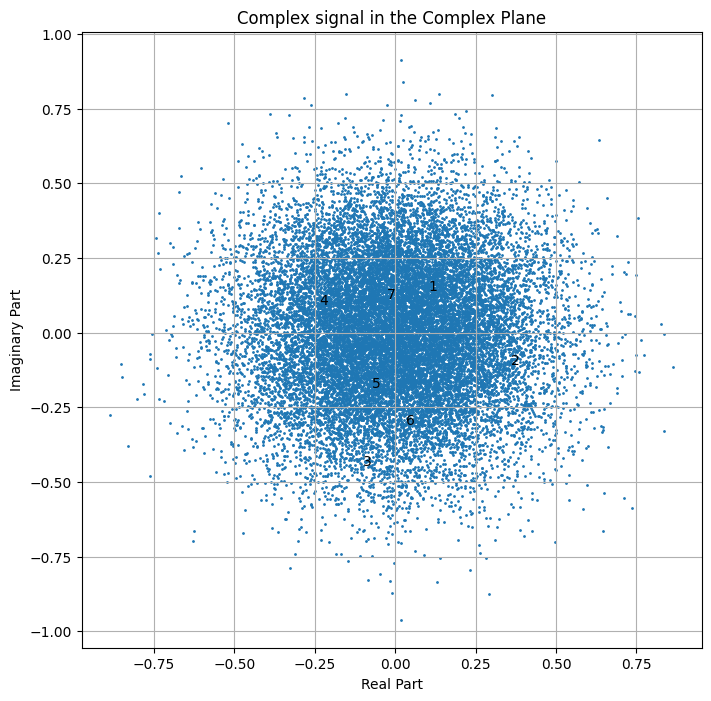

In [22]:
plt.figure(figsize=(8, 8))
plt.scatter(np.real(received_signal[:1023*20]), np.imag(received_signal[:1023*20]), s=1)

for i, txt in enumerate(range(1, 0 + 8)):
    plt.annotate(f'{txt}', (np.real(received_signal[i]), np.imag(received_signal[i])))
    
plt.title("Complex signal in the Complex Plane")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.grid(True)
plt.show()

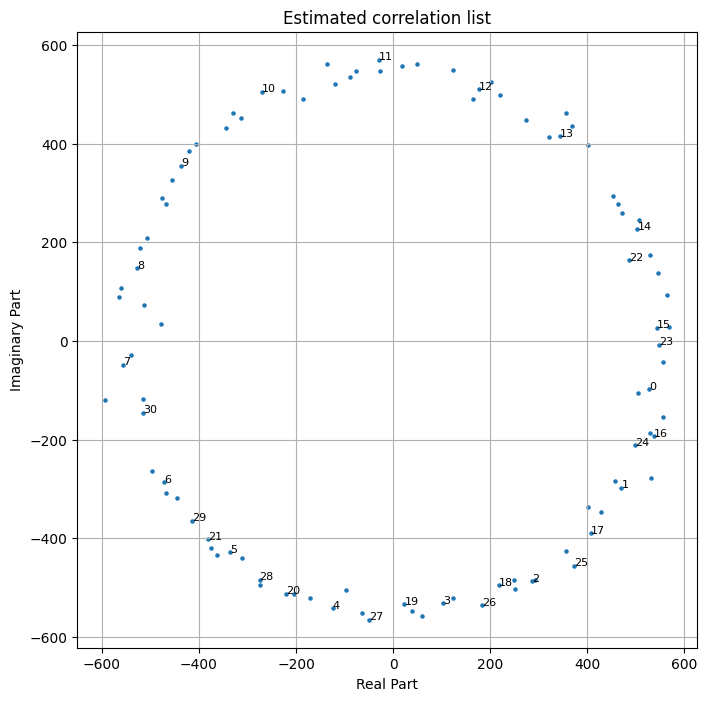

In [23]:
plt.figure(figsize=(8, 8))
plt.scatter(np.real(cor_lst), np.imag(cor_lst), s=5)

for i, txt in enumerate(range(0, 0 + 31)):
    plt.annotate(f'{txt}', (np.real(cor_lst[i]), np.imag(cor_lst[i])), fontsize = 8)
    
plt.title("Estimated correlation list")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.grid(True)
plt.show()

# 주파수 offset = 0일 때 1~20번은 오른쪽, 21~39번이 왼쪽에 있다면 bit boundary 잘 찾은거.(부호반전)
# 위아래로 돌아간 거는 noise에 의한 영향 + 약간의 주파수 offset과 code delay에 관한 거.

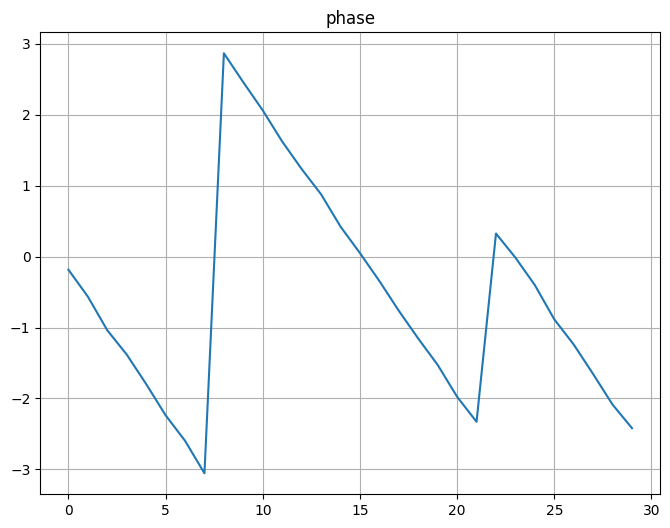

In [24]:
plt.figure(figsize=(8, 6))
plt.plot(phase[:30])
plt.title("phase")
plt.grid(True)
plt.show()

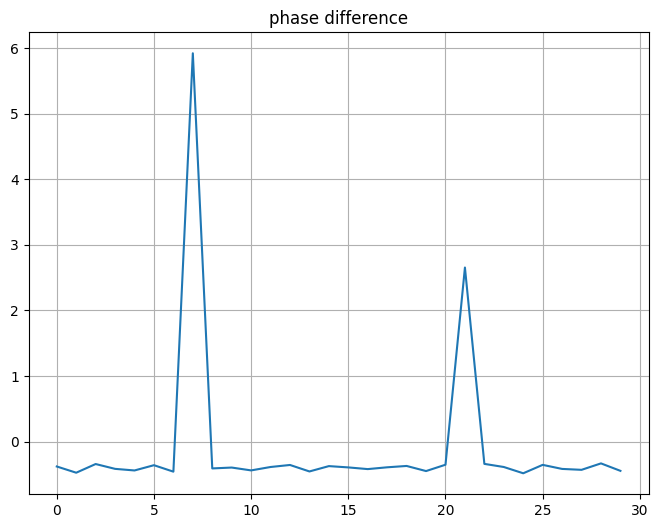

In [25]:
plt.figure(figsize=(8, 6))
plt.plot(phase_diff[:30])
plt.title("phase difference")
plt.grid(True)
plt.show()

## 밑에는

## 작업중

## 병렬구조 만들기 (Demod, DLL 하기 전)

신호를 I, Q로 쪼갠 뒤 각각을 계산해야함

In [26]:
# Extract real and imaginary parts separately
def spliter(signal):
    return np.real(signal), np.imag(signal)

real_part, imaginary_part = spliter(received_signal)

cur_code_delay = estimated_code_delay

E = generate_replica_signal(cur_code_delay - (OV // 2), estimated_doppler_freq, code_freq, svNumber)
P = generate_replica_signal(cur_code_delay, estimated_doppler_freq, code_freq, svNumber)
L = generate_replica_signal(cur_code_delay + (OV // 2), estimated_doppler_freq, code_freq, svNumber)

Real_E, Imag_E = spliter(E)
Real_P, Imag_P = spliter(P)
Real_L, Imag_L = spliter(L)

signal_div_Real = [real_part[i:i+(1023*OV)] for i in range(0,len(real_part), 1023*OV)]
signal_div_Imaginary = [imaginary_part[i:i+(1023*OV)] for i in range(0,len(imaginary_part), 1023*OV)]

def I_and_D(signal, replica):
    correlation = []
    for lst in signal:
        cor = correlate(lst, replica,mode='valid')
        correlation.append(np.max(cor))
    return list(correlation)

I_E = I_and_D(signal_div_Real, Real_E)
Q_E = I_and_D(signal_div_Imaginary, Imag_E)
I_P = I_and_D(signal_div_Real, Real_P)
Q_P = I_and_D(signal_div_Imaginary, Imag_P)
I_L = I_and_D(signal_div_Real, Real_L)
Q_L = I_and_D(signal_div_Imaginary, Imag_L)


NameError: name 'estimated_code_delay' is not defined

Demodulation

In [ ]:
Prompt = []
for i in range(len(I_P)):
    if I_P[i] > 0:
        Prompt.append(1)
    else:
        Prompt.append(-1)

print('data :', *data, sep = " ")
print('est :', *Prompt, sep = " ")


NameError: name 'I_P' is not defined

결과 Plot

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(I_P, Q_P, s = 5)

for i in range(len(I_P)):
    plt.annotate(f'{i}', (I_P[i], Q_P[i]))
    
plt.title("Demodulation result in the Complex Plane")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.grid(True)
plt.show()

NameError: name 'I_P' is not defined

<Figure size 800x600 with 0 Axes>

## Tracking loop test

fine frequency estimation (FLL)

In [ ]:
#input 재정의: 
#kLargest = doppler주파수estimation한걸로 넣
#data = received_signal로 넣ㅇㅇ
#GPS_fs = 샘플링 주파수 넣ㅇㅇ(아마?)


def GetFineFrequency(data, kLargest, GPS_fs): # now passed in data class
    # Performs fine-frequency estimation. In this case, data will be a slice
    # of data (probably same length of data that was used in the circular
    # cross-correlation)


    # Perform DFT on each of the ms of data (5 total), at kLargest frequency.
    # Uses variables from medium-frequency, so if they change, may need to re-create below.
    X = []
    PhaseAngle = []
    numMSmf = 1 # num ms for medium-frequency estimation
    Nmf = int(np.ceil(numMSmf*0.001*GPS_fs))  # num of samples to use for medium-frequency estimation (and DFT)
    # Create sampled time array for DFT
    Ts = 1/GPS_fs
    nTs = np.linspace(0,Ts*(Nmf + 1),Nmf,endpoint=False)
    
    for i in range(0,5):
        X.append(sum(data[i*1023:(i+1)*1023]*np.exp(-2*np.pi*1j*kLargest*nTs)))
        PhaseAngle.append(np.arctan(np.imag(X[i])/np.real(X[i])))
        print("Magnitude: %f" %X[i])
        print("Phase Angle: %f" %PhaseAngle[i])

    # Get difference angles
    PhaseDiff = []
    for i in range(1,5):
        PhaseDiff.append(PhaseAngle[i]-PhaseAngle[i-1])
        print("Phase difference %d, is: %f"%((i-1),PhaseDiff[i-1]))


    PhaseThreshold = (2.3*np.pi)/5
    for (i,curPhaseDiff) in enumerate(PhaseDiff):
        if np.abs(curPhaseDiff) > PhaseThreshold:
            curPhaseDiff = PhaseDiff[i] - 2*np.pi
            if np.abs(curPhaseDiff) > PhaseThreshold:
                curPhaseDiff = PhaseDiff[i] + 2*np.pi
                if np.abs(curPhaseDiff) > (2.2*np.pi)/5:
                    curPhaseDiff = PhaseDiff[i] - np.pi
                    if np.abs(curPhaseDiff) > PhaseThreshold:
                        curPhaseDiff = PhaseDiff[i] - 3*np.pi
                        if np.abs(curPhaseDiff) > PhaseThreshold:
                            curPhaseDiff = PhaseDiff[i] + np.pi
        PhaseDiff[i] = curPhaseDiff
    fList = (np.array(PhaseDiff)/(2*np.pi*0.001))
    print(fList)
    print()
    print(np.mean(fList))

    FineFrequencyEst = (np.mean(fList)) #각 데이터 슬라이스에서 계산된 위상 차이에 대한 주파수 변화율
    return FineFrequencyEst



In [ ]:
kLargest = estimated_doppler_freq
GPS_fs= code_freq
print(len(data))
FineFrequencyEst = GetFineFrequency(received_signal, kLargest, GPS_fs)

print()
print(FineFrequencyEst + estimated_doppler_freq)
print("frequency 추정 완료")



5
Magnitude: 13.253264
Phase Angle: -0.677866
Magnitude: 48.714139
Phase Angle: -0.303918
Magnitude: -9.429634
Phase Angle: 1.357951
Magnitude: -57.738349
Phase Angle: -0.326753
Magnitude: 0.426907
Phase Angle: 1.444382
Phase difference 0, is: 0.373948
Phase difference 1, is: 1.661869
Phase difference 2, is: -1.684705
Phase difference 3, is: 1.771136
[  59.51564323  764.49470096  231.8709117  -218.11501369]

209.44156054997694

1209.4415605499769
frequency 추정 완료


C:\Users\minwoo\AppData\Local\Temp\ipykernel_11468\2186035964.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
  print("Magnitude: %f" %X[i])
